In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from PIL import Image
import pandas as pd
import torch.utils.data as data
import numpy as np
from sklearn.model_selection import train_test_split
import timm
import tqdm
from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms

torch.__version__,torchvision.__version__

('2.0.1+cu117', '0.15.2+cu117')

In [3]:
torch.cuda.is_available()

True

In [5]:
import numpy as np
sample_path = "data/MRNet-v1.0/2131.npy"
knee_image_0 = np.load(sample_path)
# np.expand_dims(knee_image_0, axis=0).shape

In [6]:
# Multiple Slices in one image
knee_image_0.shape

(44, 256, 256)

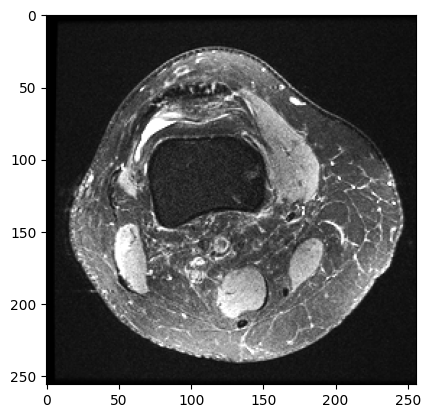

In [7]:
import matplotlib.pyplot as plt
plt.imshow(knee_image_0[10], cmap='gray')

In [8]:
slice_index = 10
axis = 0
slice_2d = knee_image_0.take(indices=slice_index, axis=axis)

array = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)
array = np.array(array)
array = np.expand_dims(array, axis=2)
array = np.repeat(array, 3, axis=2)

C:\Users\deepe\AppData\Local\Temp\ipykernel_18988\3676559968.py:5: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  array = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)


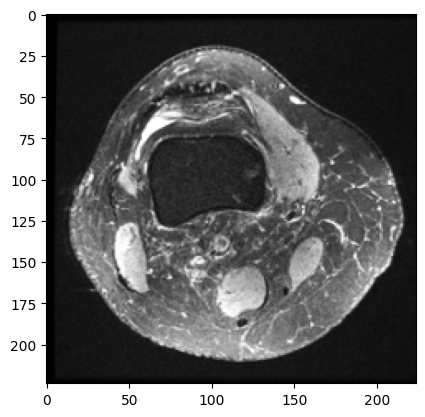

In [9]:
plt.imshow(array, cmap='gray')

In [10]:
array.shape

(224, 224, 3)

#### Experiment -1 with Lab - 04 code and Timm package

handling image details at outside level

In [11]:
root_directory = 'data/MRNet-v1.0/'

In [12]:
# Need to update for all files and classes
task = 'abnormal'
records = pd.read_csv(root_directory + 'train-{}.csv'.format(task),header=None, names=['id', f'label-{task}'])

In [13]:
records.head()

,id,label-abnormal
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [14]:
## using abnormal task and train axial files

records['id'] = records['id'].apply(lambda x : root_directory+"train/axial/"+'0' * (4 - len(str(x))) + str(x)+'.npy')

In [15]:
train_files, test_files, train_classes, test_classes = train_test_split(records['id'], records[f'label-{task}'], test_size=0.2)

In [16]:
#for validation files
# Need to update for all files and classes
task = 'abnormal'
records_val = pd.read_csv(root_directory + 'valid-{}.csv'.format(task),header=None, names=['id', f'label-{task}'])
records_val['id'] = records_val['id'].apply(lambda x : root_directory+"valid/axial/"+'0' * (4 - len(str(x))) + str(x)+'.npy')
# val_files, test_files, train_classes, test_classes = train_test_split(records['id'], records[f'label-{task}'], test_size=0.2)

In [17]:
train_classes

979     1
645     1
295     1
1008    0
1103    1
       ..
1005    0
197     1
603     1
1030    1
304     1
Name: label-abnormal, Length: 904, dtype: int64

In [18]:
# from PIL import Image
import torch.utils.data as data

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class MRDataset(data.Dataset):
    def __init__(self, root, files, classes, transforms=None, is_train = False): 
        # location of the dataset
        self.is_train = is_train
        self.root = root
        # list of files
        self.files = files
        # list of classes
        self.classes = classes
        # transforms
        self.transforms = transforms

    def __getitem__(self, item):
        # read the image
        # image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        # print(item)
        # print(self.files)
        image = np.load(self.files[item])

        # for plane in self.planes:
        # Load raw image data for each plane
        # Resize the image loaded in the previous step
        image = self._resize_image(image)
        # image = np.stack((knee_image_0,)*3, axis=1)[10]
        # slice_index = 10
        # axis = 0
        # slice_2d = image.take(indices=slice_index, axis=axis)

        # array = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)
        # array = np.array(array)
        # array = np.expand_dims(array, axis=2)
        # image = np.repeat(array, 3, axis=2)
        # print(image.shape)
        # class for that image
        if self.is_train:
            if self.classes[item] == 0:
                class_ = np.ones(image.shape[0]).T
            else:
                class_ = np.zeros(image.shape[0]).T
        else:
            class_ = self.classes[item]
        # apply transformation
        # if self.transforms:
        #     image = self.transforms(image)
        # return the image and class
        return image, class_

    def __len__(self):
        # return the total number of images
        return len(self.files)

    def _resize_image(self, image):
        """Resize the image to `(3,224,224)` and apply 
        transforms if possible.
        """
        # Resize the image
        # Calculate extra padding present in the image
        # which needs to be removed
        pad = int((image.shape[2] - INPUT_DIM)/2)
        # This is equivalent to center cropping the image
        image = image[:,pad:-pad,pad:-pad]
        # Normalize the image by subtracting it by mean and dividing by standard
        # deviation
        # image = (image-np.min(image))/(np.max(image)-np.min(image))*MAX_PIXEL_VAL
        # image = (image - MEAN) / STDDEV
        
        # If the transformation is not None
        if self.transforms:
            # Transform the image based on the specified transformation
            image = image[5:15]
            image = self.transforms(image)
        else:
            # Else, just stack the image with itself in order to match the required
            # dimensions

            ## taking only 10th slice of image will experiment on others

            image = np.stack((image,)*3, axis=1)[10:11]
        # Convert the image to a FloatTensor and return it
        image = torch.FloatTensor(image)
        return image

In [19]:
augments = Compose([
        # Convert the image to Tensor
        transforms.Lambda(lambda x: torch.Tensor(x)),
        # Randomly rotate the image with an angle
        # between -25 degrees to 25 degrees
        RandomRotate(25),
        # Randomly translate the image by 11% of 
        # image height and width
        RandomTranslate([0.11, 0.11]),
        # Randomly flip the image
        RandomFlip(),
        # Change the order of image channels
        transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(1, 0, 2, 3)),
    ])

In [20]:
# transform = torchvision.transforms.Compose([
#             torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
#             torchvision.transforms.RandomHorizontalFlip(),
#             torchvision.transforms.ToTensor()
#             # , transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#             ])
        

# define how image transformed
# transform = torchvision.transforms.Compose([
#                               #  torchvision.transforms.Resize((224, 224)),
#                                torchvision.transforms.ToTensor()
#                             #    ,torchvision.transforms.Normalize(
#                             #      (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                  ])



In [21]:
# torch.squeeze(next(iter(test_loader))[0], dim=0).shape

In [22]:
timm.list_models('vit*', pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai_ft_in1k',
 'vit_base_patch16_clip_224.op

In [23]:
model = timm.create_model('vit_small_patch16_224.augreg_in21k_ft_in1k', pretrained=True)

In [24]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [25]:
model.default_cfg

{'url': 'https://storage.googleapis.com/vit_models/augreg/S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz',
 'hf_hub_id': 'timm/vit_small_patch16_224.augreg_in21k_ft_in1k',
 'architecture': 'vit_small_patch16_224',
 'tag': 'augreg_in21k_ft_in1k',
 'custom_load': True,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

In [26]:
model.get_classifier()

Linear(in_features=384, out_features=1000, bias=True)

In [27]:
# output = model(torch.squeeze(next(iter(test_loader))[0], dim=0))
# print(output.shape)

In [28]:
timm.create_model('vit_small_patch16_224.augreg_in21k_ft_in1k', pretrained=True, num_classes = 0).get_classifier()

Identity()

In [29]:
# # prediction = model(torch.squeeze(next(iter(test_loader))[0], dim=0))[0]

# prediction = model.forward(torch.squeeze(next(iter(test_loader))[0], dim=0))[0]

# #         loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
# # criterion = torch.nn.BCEWithLogitsLoss()
# # loss = criterion(prediction,label)

# # loss_value = loss.item()
# # losses.append(loss_value)

# probas = torch.sigmoid(prediction)

In [31]:
batch_size_train = 1
batch_size_test = 1

# image datasets
train_dataset = MRDataset(root_directory, records['id'], records[f'label-{task}'], 
                         transforms=augments,is_train = True)
test_dataset = MRDataset(root_directory, records_val['id'], records_val[f'label-{task}'])
# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [32]:
# next(iter(train_dataset))[1]

In [33]:
#  Create Model
device = "cuda"
model = dinoViTSmall()
model = model.to(device)

In [34]:
# from torch import optim
# learning_rate = 0.0001
# opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

# model.train()
# pbar = tqdm.tqdm(train_loader)
# for x,label in pbar:
#     print(x.shape)
#     print(label.shape)
#     x,label = x.float().to(device),label.T.to(device)
#     pred = model.forward(x)
#     # print(label)
#     # loss = nn.functional.cross_entropy(pred,label)
#     loss = nn.BCEWithLogitsLoss()
#     loss = loss(pred,label)
#     # loss = nn.MSELoss(pred,label)
#     loss.backward()
#     opt.step()
#     opt.zero_grad()
#     pbar.set_description(f"loss: {loss.item():.3f}")

In [35]:
# print(pred.shape)
# print(label.T.shape)

In [36]:
import tqdm

def train_one_epoch(dl,model, opt, device):
    model.train()
    pbar = tqdm.tqdm(dl)
    for x,label in pbar:        
        x,label = x.float().to(device),label.T.to(device)
        pred = model.forward(x)
        # print(label)
        # loss = nn.functional.cross_entropy(pred,label)
        loss = nn.BCEWithLogitsLoss()
        loss = loss(pred,label)
        # loss = nn.MSELoss(pred,label)
        loss.backward()
        opt.step()
        opt.zero_grad()
        pbar.set_description(f"loss: {loss.item():.3f}")

@torch.no_grad()
def eval_one_epoch(dl,model, device):
    model.eval()
    pbar = tqdm.tqdm(dl)
    def _f():
        for x,label in pbar:
            x,label = x.to(device),label.to(device).float().unsqueeze(1)
            pred = model(x)
            # loss = nn.functional.cross_entropy(pred,label)
            loss = nn.BCEWithLogitsLoss()
            loss = loss(pred,label)
            # loss = nn.MSELoss(pred,label)
            acc = (pred.argmax(1)==label).float().mean()
            pbar.set_description(f"loss: {loss.item():.3f}, acc: {acc.item():.3f}")
            yield pred.argmax(1),label
    out = list(_f())
    pred, y = list(zip(*out))
    return torch.cat(pred),torch.cat(y)

loss: nan, acc: 0.000: 100%|██████████| 120/120 [00:02<00:00, 55.88it/s]


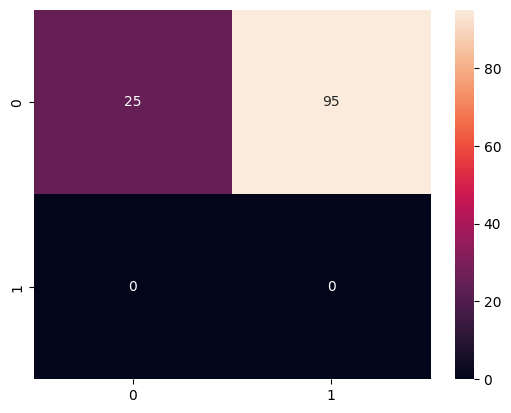

0 0.2083333432674408


loss: nan:  92%|█████████▏| 1037/1130 [02:47<00:15,  6.19it/s]


KeyboardInterrupt: 

In [41]:
from torch import optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

learning_rate = 0.1
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_epoch = 2
log=[]
for epoch in range(num_epoch):
    train_one_epoch(train_loader,model, optimizer, device)
    # if epoch%10==0:
    pred,y = eval_one_epoch(test_loader,model, device)
    acc = (pred==y).float().mean().item()        
    log.append(acc)

    cf_max=confusion_matrix(pred.cpu(),y.cpu())
    sns.heatmap(cf_max,annot=True,fmt='g')
    plt.show()
    print(epoch, acc)

In [39]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import classification_report
# import torch.nn.functional as F

# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count


# from tqdm.notebook import tqdm
# ##define train function
# def train(model, device, train_loader, optimizer):
#     # meter
#     loss = AverageMeter()
#     acc = AverageMeter()
#     correct = 0
#     # switch to train mode
#     model.train()
#     tk0 = tqdm(train_loader, total=int(len(train_loader)))
#     for batch_idx, (data, target) in enumerate(tk0):
#     # for data, target in train_loader:
#         # print(batch_idx)
#         # after fetching the data transfer the model to the 
#         # required device, in this example the device is gpu
#         # transfer to gpu can also be done by 
#         # data, target = data.cuda(), target.cuda()
#         data, target = data.to(device), target.T.to(device)  
#         # compute the forward pass
#         # it can also be achieved by model.forward(data)
#         output = model(data) 
#         # compute the loss function
#         # loss_this = F.mse_loss(output, target)
#         loss = nn.BCEWithLogitsLoss()
#         loss_this = loss(output, target)
#         # initialize the optimizer
#         optimizer.zero_grad()
#         # compute the backward pass
#         loss_this.backward()
#         # update the parameters
#         optimizer.step()
#         # update the loss meter 
#         # loss.update(loss_this.item(), target.shape[0])
#         # get the index of the max log-probability
#         pred = output.argmax(dim=1, keepdim=True) 
#         # check which of the predictions are correct
#         correct_this = pred.eq(target.view_as(pred)).sum().item()
#         # accumulate the correct ones
#         correct += correct_this
#         # compute accuracy
#         acc_this = correct_this/target.shape[0]*100.0
#         # update the loss and accuracy meter 
#         acc.update(acc_this, target.shape[0])


#         # if batch_idx%10 == 0:
#         # print("jk")
#         # print('Train: Average loss: {:.4f}\n'.format(loss.avg)) 
#     #     if batch_idx % 10 == 0:
#     #         print('train: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(loss.avg, correct, len(train_loader.dataset), acc.avg))

#     # print('Train: Average loss: {:.4f}\n, Accuracy: {}/{} ({:.2f}%)\n'.format(loss.avg, correct, len(train_loader.dataset), acc.avg))

#     # return loss.avg

# def arr_1(arr):
#     r = []
#     for i in arr:
#         r.append(i[0])
#     return r       

# ##define test function
# def test(model, device, test_loader):
#     # meters
#     loss = AverageMeter()
#     acc = AverageMeter()
#     correct = 0
#     # switch to test mode
#     model.eval()
#     ground_truth = []
#     np_array = []
#     for data, target in test_loader:
#         # after fetching the data transfer the model to the 
#         # required device, in this example the device is gpu
#         # transfer to gpu can also be done by 
#         # data, target = data.cuda(), target.cuda()
#         data, target = data.to(device), target.to(device).float().unsqueeze(1)  # data, target = data.cuda(), target.cuda()
#         # since we dont need to backpropagate loss in testing,
#         # we dont keep the gradient
#         with torch.no_grad():
#             # compute the forward pass
#             # it can also be achieved by model.forward(data)
#             output = model(data)
#         # compute the loss function just for checking
#         # loss_this = F.mse_loss(output, target)
#         loss = nn.BCEWithLogitsLoss()
#         loss_this = loss(output, target)
#         # get the index of the max log-probability
#         pred = output.argmax(dim=1, keepdim=True) 

#         ground_truth.extend(np.argmax(output.to('cpu').numpy(),axis=-1))
#         np_array.extend(arr_1(target.to('cpu').numpy().astype('int64')))

#         # check which of the predictions are correct
#         correct_this = pred.eq(target.view_as(pred)).sum().item()
#         # accumulate the correct ones
#         correct += correct_this
#         # compute accuracy
#         acc_this = correct_this/target.shape[0]*100.0
#         # update the loss and accuracy meter 
#         acc.update(acc_this, target.shape[0])
#         # loss.update(loss_this.item(), target.shape[0])

#     # print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(loss.avg, correct, len(test_loader.dataset), acc.avg))
    
#     print("Classification report:")
#     # y_pred = model.predict(X_test)

#     print(classification_report(ground_truth, np_array, labels=[0,1], target_names=['Absent', 'Present']))
#     # print("Test accuracy:",accuracy_score(target, output))

#     labels = [0,1]
    
#     matrix = confusion_matrix(ground_truth, np_array)
#     print(pd.DataFrame(matrix,columns=labels, index=labels))
#     fig, ax = plt.subplots(figsize=(10, 10))

#     # plot the confusion matrix with labels
#     cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)

#     # plot the confusion matrix on the specified axes object
#     cm_display.plot(ax=ax)
#     plt.show()


In [ ]:
# num_epoch = 2
# for epoch in range(1, num_epoch + 1):
#     train(model, device, train_loader, optimizer)
# test(model, device, test_loader)

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([1, 1]))